## Helpers

In [1]:
import sys
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re

In [2]:
def parse_coverage_file(filename):
    with open(filename, 'r') as f:
        lines = f.readlines()
    data_lines = []
    data_section = False

    for line in lines:
        if re.match(r'^Filename\s+Regions', line):
            data_section = True
            continue
        if re.match(r'^Files which contain no functions', line):
            data_section = False
        if re.match(r'^TOTAL', line):
            data_section = True
        if data_section and len(line.strip()) > 0 and not line.startswith('---') and not line.startswith('SUMM'):
            data_lines.append(line)

    records = []
    for line in data_lines:
        parts = re.split(r'\s+', line.strip(), maxsplit=13)
        if len(parts) < 12:
            continue
        filename = parts[0]
        regions = int(parts[1])
        missed_regions = int(parts[2])
        region_coverage = float(parts[3].strip('%'))

        functions = parts[4]
        if functions.isdigit():
            functions = int(functions)
            missed_functions = int(parts[5])
            function_coverage = float(parts[6].strip('%'))
        else:
            functions = 0
            missed_functions = 0
            function_coverage = 0.0

        lines_count = int(parts[7])
        missed_lines = int(parts[8])
        line_coverage = float(parts[9].strip('%'))

        branches = parts[10]
        if branches.isdigit():
            branches = int(branches)
            missed_branches = int(parts[11])
            branch_coverage = 0.0
            if parts[12] == '-':
              branch_coverage = 100.0
            else:
              branch_coverage = float(parts[12].strip('%'))
        else:
            branches = 0
            missed_branches = 0
            branch_coverage = 0.0

        records.append({
            'filename': filename,
            'region_coverage': region_coverage,
            'function_coverage': function_coverage,
            'line_coverage': line_coverage,
            'branch_coverage': branch_coverage
        })

    return pd.DataFrame(records)

In [5]:
def create_output_dir(output_dir='coverage_analysis'):
    if not os.path.exists(output_dir):
        os.makedirs(output_dir)
    return output_dir

In [41]:
def plot_overall_comparison(afl_df, afl_gcd_df, afl_mcmc_df, output_dir):
    afl_total = afl_df[afl_df['filename'] == 'TOTAL'].iloc[0]
    afl_gcd_total = afl_gcd_df[afl_gcd_df['filename'] == 'TOTAL'].iloc[0]
    afl_mcmc_total = afl_mcmc_df[afl_mcmc_df['filename'] == 'TOTAL'].iloc[0]

    metrics = [
        ('region_coverage', 'Region Coverage'),
        ('function_coverage', 'Function Coverage'),
        ('line_coverage', 'Line Coverage'),
        ('branch_coverage', 'Branch Coverage')
    ]

    values = []
    labels = []
    improvements_gcd = []
    improvements_mcmc = []

    for metric_key, metric_label in metrics:
        afl_value = afl_total[metric_key]
        afl_gcd_value = afl_gcd_total[metric_key]
        afl_mcmc_value = afl_mcmc_total[metric_key]

        improvement_gcd = afl_gcd_value - afl_value
        improvement_mcmc = afl_mcmc_value - afl_value

        values.append((afl_value, afl_gcd_value, afl_mcmc_value))
        labels.append(metric_label)
        improvements_gcd.append(improvement_gcd)
        improvements_mcmc.append(improvement_mcmc)

    plt.figure(figsize=(12, 7))
    x = np.arange(len(labels))
    width = 0.25

    plt.bar(x - width, [v[0] for v in values], width, label='AFL++ Only', color='#6495ED')
    plt.bar(x, [v[1] for v in values], width, label='AFL++ w/ GCD', color='#FFA500')
    plt.bar(x + width, [v[2] for v in values], width, label='AFL++ w/ MCMC', color='#2E8B57')

    max_value = max([max(v) for v in values])
    y_padding = max_value * 0.15
    plt.ylim(0, max_value + y_padding)

    for i, v in enumerate(values):
        plt.text(i - width, v[0] + 0.1, f'{v[0]:.2f}%', ha='center', va='bottom', fontsize=8)
        plt.text(i, v[1] + 0.1, f'{v[1]:.2f}%', ha='center', va='bottom', fontsize=8)
        plt.text(i + width, v[2] + 0.1, f'{v[2]:.2f}%', ha='center', va='bottom', fontsize=8)

        y_pos = max(v) + (y_padding * 0.3)

        plt.text(i - width/2, y_pos, f'+{improvements_gcd[i]:.2f}%',
                ha='center', va='bottom', color='#FFA500', fontsize=9)
        plt.text(i + width/2, y_pos, f'+{improvements_mcmc[i]:.2f}%',
                ha='center', va='bottom', color='red', fontsize=9)

    plt.ylabel('Coverage (%)')
    plt.title('Overall Coverage: AFL++ vs AFL++ w/ GCD seeds vs AFL++ w/ MCMC seeds')
    plt.xticks(x, labels)
    plt.legend()
    plt.tight_layout()
    plt.show()
    plt.savefig(f'{output_dir}/overall_comparison.png', dpi=300)
    plt.close()

In [42]:
def merge_coverage_dataframes(afl_df, afl_gcd_df, afl_mcmc_df):
    afl_df_renamed = afl_df.copy()
    afl_gcd_df_renamed = afl_gcd_df.copy()
    afl_mcmc_df_renamed = afl_mcmc_df.copy()

    coverage_metrics = ['region_coverage', 'function_coverage', 'line_coverage', 'branch_coverage']

    for metric in coverage_metrics:
        afl_gcd_df_renamed = afl_gcd_df_renamed.rename(columns={
            metric: f"{metric}_afl_gcd"
        })
        afl_mcmc_df_renamed = afl_mcmc_df_renamed.rename(columns={
            metric: f"{metric}_afl_mcmc"
        })
        afl_df_renamed = afl_df_renamed.rename(columns={
            metric: f"{metric}_afl"
        })

    merged_df = afl_df_renamed.merge(
        afl_gcd_df_renamed, on='filename', suffixes=('', '_gcd')
    ).merge(
        afl_mcmc_df_renamed, on='filename', suffixes=('', '_mcmc')
    )

    for metric in coverage_metrics:
        afl_col = f"{metric}_afl"
        gcd_col = f"{metric}_afl_gcd"
        mcmc_col = f"{metric}_afl_mcmc"

        merged_df[f"{metric}_improvement_gcd"] = merged_df[gcd_col] - merged_df[afl_col]
        merged_df[f"{metric}_improvement_mcmc"] = merged_df[mcmc_col] - merged_df[afl_col]

    return merged_df

In [43]:
def plot_top_files_comparison(merged_df, output_dir, top_n=8):
    print("Generating top files comparison chart...")

    top_files = merged_df[merged_df['filename'] != 'TOTAL'].nlargest(top_n, 'region_coverage_improvement_mcmc')

    plt.figure(figsize=(14, 8))
    files = top_files['filename']
    x = np.arange(len(files))
    width = 0.25

    plt.bar(x - width, top_files['region_coverage_afl'], width, label='AFL++ Only', color='#6495ED')
    plt.bar(x, top_files['region_coverage_afl_gcd'], width, label='AFL++ w/ GCD', color='#FFA500')
    plt.bar(x + width, top_files['region_coverage_afl_mcmc'], width, label='AFL++ w/ MCMC', color='#2E8B57')

    max_height = top_files[['region_coverage_afl', 'region_coverage_afl_gcd', 'region_coverage_afl_mcmc']].max().max()
    y_padding = max_height * 0.15
    plt.ylim(0, max_height + y_padding)

    for i, (_, row) in enumerate(top_files.iterrows()):
        gcd_improvement = row['region_coverage_improvement_gcd']
        mcmc_improvement = row['region_coverage_improvement_mcmc']

        max_bar_height = max(row['region_coverage_afl'],
                           row['region_coverage_afl_gcd'],
                           row['region_coverage_afl_mcmc'])

        plt.text(i - width/2, max_bar_height + (y_padding * 0.3), f'+{gcd_improvement:.2f}%',
                 ha='center', va='bottom', color='#FFA500', fontsize=9)
        plt.text(i + width/2, max_bar_height + (y_padding * 0.6), f'+{mcmc_improvement:.2f}%',
                 ha='center', va='bottom', color='red', fontsize=9)

    plt.ylabel('Region Coverage (%)')
    plt.title('Region Coverage Comparison for Top Improved Files')
    plt.xticks(x, files, rotation=45, ha='right')
    plt.legend()
    plt.tight_layout()
    plt.show()
    plt.savefig(f'{output_dir}/top_files_comparison.png', dpi=300)
    plt.close()

In [44]:
def save_results(merged_df, output_dir):
    print("Saving detailed results to CSV...")

    improved_files = merged_df[
        (merged_df['region_coverage_improvement_gcd'] > 0) | (merged_df['region_coverage_improvement_mcmc'] > 0) |
        (merged_df['function_coverage_improvement_gcd'] > 0) | (merged_df['function_coverage_improvement_mcmc'] > 0) |
        (merged_df['line_coverage_improvement_gcd'] > 0) | (merged_df['line_coverage_improvement_mcmc'] > 0) |
        (merged_df['branch_coverage_improvement_gcd'] > 0) | (merged_df['branch_coverage_improvement_mcmc'] > 0)
    ].copy()

    results_df = improved_files[[
        'filename',
        'region_coverage_afl', 'region_coverage_afl_gcd', 'region_coverage_afl_mcmc',
        'region_coverage_improvement_gcd', 'region_coverage_improvement_mcmc',
        'function_coverage_afl', 'function_coverage_afl_gcd', 'function_coverage_afl_mcmc',
        'function_coverage_improvement_gcd', 'function_coverage_improvement_mcmc',
        'line_coverage_afl', 'line_coverage_afl_gcd', 'line_coverage_afl_mcmc',
        'line_coverage_improvement_gcd', 'line_coverage_improvement_mcmc',
        'branch_coverage_afl', 'branch_coverage_afl_gcd', 'branch_coverage_afl_mcmc',
        'branch_coverage_improvement_gcd', 'branch_coverage_improvement_mcmc'
    ]]

    max_improvements = results_df[['region_coverage_improvement_gcd', 'region_coverage_improvement_mcmc']].max(axis=1)
    results_df.loc[:, 'max_region_improvement'] = max_improvements

    results_df = results_df.sort_values('max_region_improvement', ascending=False)
    results_df = results_df.drop(columns=['max_region_improvement'])
    results_df.to_csv(f'{output_dir}/detailed_improvements.csv', index=False)

## 1 hour run

In [45]:
afl_file = '/content/afl-base-1hr.txt'
afl_gcd_file = '/content/afl-gcd-1hr-20seed.txt'
afl_mcmc_file = '/content/afl-mcmc-1hr-20seed.txt'

print(f"Analyzing coverage reports:")
print(f"  AFL++ Only: {afl_file}")
print(f"  AFL++ w/ GCD seeds: {afl_gcd_file}")
print(f"  AFL++ w/ MCMC sampling seeds: {afl_mcmc_file}")

afl_df = parse_coverage_file(afl_file)
afl_gcd_df = parse_coverage_file(afl_gcd_file)
afl_mcmc_df = parse_coverage_file(afl_mcmc_file)

output_dir = create_output_dir()
print(f"Output will be saved to: {output_dir}/")

Analyzing coverage reports:
  AFL++ Only: /content/afl-base-1hr.txt
  AFL++ w/ GCD seeds: /content/afl-gcd-1hr-20seed.txt
  AFL++ w/ MCMC sampling seeds: /content/afl-mcmc-1hr-20seed.txt
Output will be saved to: coverage_analysis/


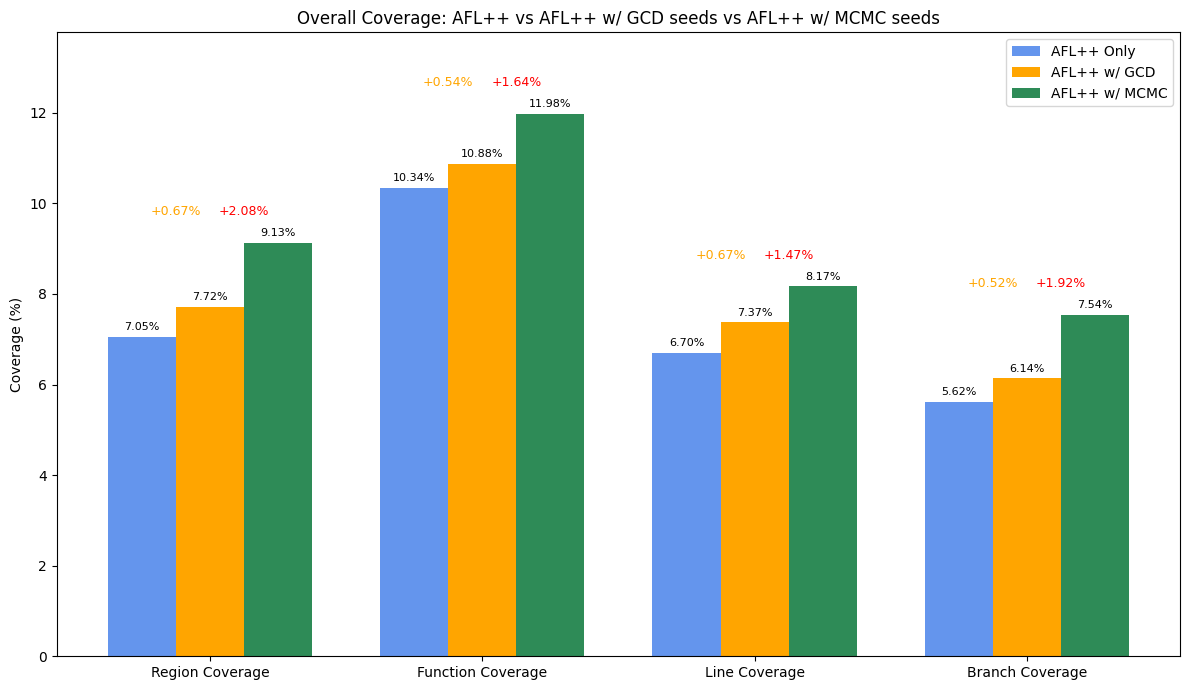

In [46]:
plot_overall_comparison(afl_df, afl_gcd_df, afl_mcmc_df, output_dir)

In [47]:
merged_df = merge_coverage_dataframes(afl_df, afl_gcd_df, afl_mcmc_df)

Generating top files comparison chart...


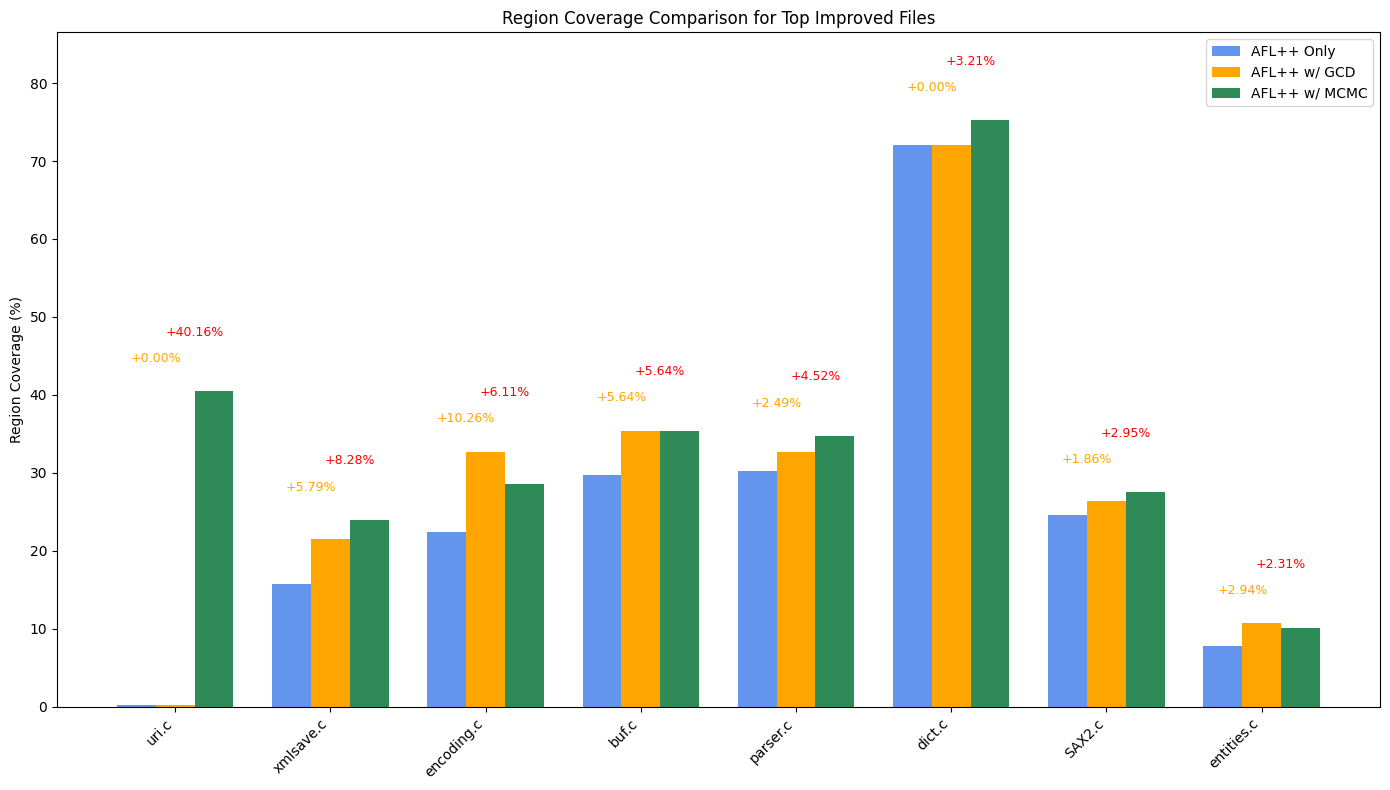

In [48]:
plot_top_files_comparison(merged_df, output_dir)

In [49]:
save_results(merged_df, output_dir)

Saving detailed results to CSV...


<ipython-input-44-17e97843a11d>:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  results_df.loc[:, 'max_region_improvement'] = max_improvements
